In [ ]:
#Reference :
#RandomForest
#https://github.com/apache/spark/blob/v2.2.0/mllib/src/main/scala/org/apache/spark/ml/classification/RandomForestClassifier.scala#L120
#One hot encoding
#https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa


In [1]:
!pip install --upgrade pip
!pip install --upgrade pandas
!pip install --upgrade google-api-python-client
!pip install --upgrade seaborn
!pip install --upgrade networkx
!pip install --upgrade matplotlib
!pip install --upgrade pyspark
!pip install --upgrade pyspark_dist_explore


    100% |████████████████████████████████| 1.3MB 13.9MB/s ta 0:00:01
pyspark 2.3.1 requires py4j==0.10.7, which is not installed.
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
Requirement already up-to-date: pandas in /opt/conda/lib/python3.6/site-packages (0.23.4)
    100% |████████████████████████████████| 61kB 4.0MB/s ta 0:00:011
    100% |████████████████████████████████| 71kB 7.3MB/s ta 0:00:011
    100% |████████████████████████████████| 215kB 12.1MB/s ta 0:00:01
    100% |████████████████████████████████| 1.7MB 18.9MB/s ta 0:00:01
  Running setup.py bdist_wheel for networkx ... done
  Stored in directory: /root/.cache/pip/wheels/68/f8/29/b53346a112a07d30a5a84d53f19aeadaa1a474897c0423af91
Successfully built networkx
    100% |████████████████████████████████| 12.9MB 3.2MB/s eta 0:00:01
  Found existing installation: matplotlib 3.0.1
    Uninstalling matplotlib-3.0.1:
      Successfully uninstalled matplotlib-3.0.

  Running setup.py bdist_wheel for pyspark ... done
  Stored in directory: /root/.cache/pip/wheels/cd/54/c2/abfcc942eddeaa7101228ebd6127a30dbdf903c72db4235b23
Successfully built pyspark
  Found existing installation: pyspark 2.3.1
    Can't uninstall 'pyspark'. No files were found to uninstall.


In [3]:
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML, display_html #usefull to display wide tables
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import functions as F, types
import datetime
from pyspark.sql.functions import col, row_number, concat, lit
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import trim


In [4]:
%matplotlib inline


In [4]:
spark

In [5]:
sc = spark.sparkContext

In [6]:
sc.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.dir', 'hdfs://cluster-w261-m/user/spark/eventlog'),
 ('spark.yarn.am.memory', '640m'),
 ('spark.executor.cores', '4'),
 ('spark.app.id', 'application_1543976567965_0002'),
 ('spark.driver.appUIAddress',
  'http://cluster-w261-m.c.w266-203603.internal:4040'),
 ('spark.driver.port', '43377'),
 ('spark.executor.instances', '2'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'cluster-w261-m'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.yarn.historyServer.address', 'cluster-w261-m:18080'),
 ('spark.driver.maxResultSize', '3840m'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter'),
 ('spark.history.fs.logDirectory',
  'hdfs://cluster-w261-m/user/spark/eventlog'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_URI_BASES',
  'ht

In [ ]:
#https://blog.cloudera.com/blog/2015/03/how-to-tune-your-apache-spark-jobs-part-2/

#The number of cores can be specified with the --executor-cores flag when invoking 
#spark-submit, spark-shell, and pyspark from the command line, 
#or by setting the spark.executor.cores property in the spark-defaults.conf file 
#or on a SparkConf object.

#The cores property controls the number of concurrent tasks an executor can run. 
#--executor-cores 5 means that each executor can run a maximum of five tasks at the same time.

#The heap size can be controlled with the --executor-memory flag 
#or the spark.executor.memory property
#The memory property impacts the amount of data Spark can cache, 
#as well as the maximum sizes of the shuffle data structures used for grouping, aggregations, and joins.

#The --num-executors command-line flag or spark.executor.instances configuration property 
#control the number of executors requested. Starting in CDH 5.4/Spark 1.3, 
#you will be able to avoid setting this property by turning on dynamic allocation with the spark.dynamicAllocation.enabled property. Dynamic allocation enables a Spark application to request executors 
#when there is a backlog of pending tasks and free up executors when idle.


In [ ]:
# spark.conf.set("spark.executor.memory", '19g')
# spark.conf.set('spark.executor.cores', '5')
# sc = spark.sparkContext


In [17]:
def f_calc_stats(data, column):
        return data.agg(F.avg(data[column]), F.min(data[column]), F.max(data[column]), \
                        F.stddev_pop(data[column]),F.var_pop(data[column]),F.skewness(data[column]) \
                       ).collect()

In [18]:
def f_check_null(data, column):
    return data.filter( (data[column] =="") |F.isnull(data[column])|F.isnan(data[column])
                      ).count()

In [19]:
def f_display_stats(data):
    dict1={}
    countTotal = data.count()
    for colname in [item[0] for item in data.dtypes if item[1].startswith('int')]:
        list1=f_calc_stats(data,colname)
        mean_val, min_val,max_val,stddev,var, skewness =list1[0]
        count_nulls = f_check_null(data,colname)
        dict1[colname]={}
        dict1[colname]['mean'] = str(round(mean_val,2))
        dict1[colname]['min'] = str(min_val)
        dict1[colname]['max'] = str(max_val)
        dict1[colname]['stddev'] = str(round(stddev,2))
        dict1[colname]['var'] = str(round(var,2))
        dict1[colname]['skewness'] = str(round(skewness,2))
        dict1[colname]['nulls_nans'] = str(count_nulls)
        dict1[colname]['pct_nulls_nans'] = str(round(float(count_nulls/countTotal*100),2))
    #Transposing dataframe to keep column names as rows
    display(HTML(pd.DataFrame(dict1).T.to_html( )))

In [7]:
#Create dataframe from RDD
def f_covert_to_df(rdd, col_list):
    return rdd.map(lambda x: x.split('\t')).toDF(col_list)

In [8]:
#Convert integer columns to IntegerType from String
def f_cast_str_to_int(df, integer_col_list):
    for col in integer_col_list:
        df = df.withColumn(col, df[col].cast(types.IntegerType()))
    return df

In [95]:
#Removing rows where at least one column has empty string
def f_remove_empty_string(df, categ_col_list):
    for categ_col in categ_col_list:
        df = df.filter(col(categ_col) != "")
    return df

In [111]:
#Converting categorical variables to one-hot encoding
def f_onehot_encoding(df,label_col_list, int_col_list, categ_col_list):
    stages=[]
    for categoricalCol in categ_col_list:
        stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
        stages += [stringIndexer, encoder]
        
    #Skip for test data    
    if label_col_list is not None:
        labelColStr=''.join(label_col_list)
        label_stringIdx = StringIndexer(inputCol = labelColStr, outputCol = 'label')
        stages += [label_stringIdx]

    assemblerInputs = [c + "classVec" for c in categ_col_list] + int_col_list
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]

    cols = df.columns

    pipeline = Pipeline(stages = stages)
    pipelineModel = pipeline.fit(df)

    df = pipelineModel.transform(df)

    if label_col_list is not None:
        selectedCols = ['label', 'features'] + cols
    else:
        selectedCols = ['features'] + cols
        
    df = df.select(selectedCols)

    return df

In [9]:
trainRDD = sc.textFile('gs://bucket-w261-final/data/train.txt',50)
trainRDD.cache()

gs://bucket-w261-final/data/train.txt MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [10]:
testRDD = sc.textFile('gs://bucket-w261-final/data/test.txt',50)
testRDD.cache()

gs://bucket-w261-final/data/test.txt MapPartitionsRDD[3] at textFile at NativeMethodAccessorImpl.java:0

In [11]:
labelColList=["clicked_0_1"]
intColList=["int_1", "int_2", "int_3", "int_4", "int_5", "int_6", "int_7", "int_8", "int_9", "int_10", "int_11", "int_12", "int_13"]
categColList=["categ_1", "categ_2", "categ_3", "categ_4", "categ_5", "categ_6", "categ_7", "categ_8", "categ_9", "categ_10", "categ_11", "categ_12", "categ_13", "categ_14", "categ_15", "categ_16", "categ_17", "categ_18", "categ_19", "categ_20", "categ_21", "categ_22", "categ_23", "categ_24", "categ_25", "categ_26"]


In [12]:
colList=[]
colList=labelColList+intColList+categColList
trainDF = f_covert_to_df(trainRDD,colList)
trainDF.cache()

DataFrame[clicked_0_1: string, int_1: string, int_2: string, int_3: string, int_4: string, int_5: string, int_6: string, int_7: string, int_8: string, int_9: string, int_10: string, int_11: string, int_12: string, int_13: string, categ_1: string, categ_2: string, categ_3: string, categ_4: string, categ_5: string, categ_6: string, categ_7: string, categ_8: string, categ_9: string, categ_10: string, categ_11: string, categ_12: string, categ_13: string, categ_14: string, categ_15: string, categ_16: string, categ_17: string, categ_18: string, categ_19: string, categ_20: string, categ_21: string, categ_22: string, categ_23: string, categ_24: string, categ_25: string, categ_26: string]

In [13]:
colList=[]
colList=intColList+categColList
testDF = f_covert_to_df(testRDD,colList)
testDF.cache()

DataFrame[int_1: string, int_2: string, int_3: string, int_4: string, int_5: string, int_6: string, int_7: string, int_8: string, int_9: string, int_10: string, int_11: string, int_12: string, int_13: string, categ_1: string, categ_2: string, categ_3: string, categ_4: string, categ_5: string, categ_6: string, categ_7: string, categ_8: string, categ_9: string, categ_10: string, categ_11: string, categ_12: string, categ_13: string, categ_14: string, categ_15: string, categ_16: string, categ_17: string, categ_18: string, categ_19: string, categ_20: string, categ_21: string, categ_22: string, categ_23: string, categ_24: string, categ_25: string, categ_26: string]

In [14]:
trainDF = f_cast_str_to_int(trainDF,intColList)
trainDF.cache()

DataFrame[clicked_0_1: string, int_1: int, int_2: int, int_3: int, int_4: int, int_5: int, int_6: int, int_7: int, int_8: int, int_9: int, int_10: int, int_11: int, int_12: int, int_13: int, categ_1: string, categ_2: string, categ_3: string, categ_4: string, categ_5: string, categ_6: string, categ_7: string, categ_8: string, categ_9: string, categ_10: string, categ_11: string, categ_12: string, categ_13: string, categ_14: string, categ_15: string, categ_16: string, categ_17: string, categ_18: string, categ_19: string, categ_20: string, categ_21: string, categ_22: string, categ_23: string, categ_24: string, categ_25: string, categ_26: string]

In [15]:
testDF = f_cast_str_to_int(testDF,intColList)
testDF.cache()

DataFrame[int_1: int, int_2: int, int_3: int, int_4: int, int_5: int, int_6: int, int_7: int, int_8: int, int_9: int, int_10: int, int_11: int, int_12: int, int_13: int, categ_1: string, categ_2: string, categ_3: string, categ_4: string, categ_5: string, categ_6: string, categ_7: string, categ_8: string, categ_9: string, categ_10: string, categ_11: string, categ_12: string, categ_13: string, categ_14: string, categ_15: string, categ_16: string, categ_17: string, categ_18: string, categ_19: string, categ_20: string, categ_21: string, categ_22: string, categ_23: string, categ_24: string, categ_25: string, categ_26: string]

In [ ]:
# %%time
# trainDF.groupby('int_1').count().sort("count",ascending=False).show(10)


In [ ]:
%%time
f_display_stats(trainDF)


In [106]:
#Creating a subset for analysis
trainsubsetDF=trainDF.limit(50000)
trainsubsetDF=trainsubsetDF.na.drop()
trainsubsetDF.cache()
testsubsetDF=testDF.limit(50000)
testsubsetDF=testsubsetDF.na.drop()
testsubsetDF.cache()

DataFrame[int_1: int, int_2: int, int_3: int, int_4: int, int_5: int, int_6: int, int_7: int, int_8: int, int_9: int, int_10: int, int_11: int, int_12: int, int_13: int, categ_1: string, categ_2: string, categ_3: string, categ_4: string, categ_5: string, categ_6: string, categ_7: string, categ_8: string, categ_9: string, categ_10: string, categ_11: string, categ_12: string, categ_13: string, categ_14: string, categ_15: string, categ_16: string, categ_17: string, categ_18: string, categ_19: string, categ_20: string, categ_21: string, categ_22: string, categ_23: string, categ_24: string, categ_25: string, categ_26: string]

In [92]:
trainsubsetDF.count()

5898

In [107]:
#Removing rows where at least one column has empty string

trainsubsetDF= f_remove_empty_string(trainsubsetDF, categColList)
testsubsetDF= f_remove_empty_string(testsubsetDF, categColList)


In [22]:
%%time
f_display_stats(trainsubsetDF)


,max,mean,min,nulls_nans,pct_nulls_nans,skewness,stddev,var
int_1,156,5.16,0,0,0.0,5.49,11.71,137.21
int_2,5756,93.48,-2,0,0.0,7.44,346.7,120198.25
int_3,1995,15.04,0,0,0.0,25.3,46.86,2195.8
int_4,81,8.81,0,0,0.0,2.03,9.33,87.07
int_5,75952,1973.64,0,0,0.0,6.1,3580.3,12818518.58
int_6,3884,92.03,0,0,0.0,7.85,222.87,49672.0
int_7,3322,51.6,0,0,0.0,10.57,142.4,20278.6
int_8,54,19.86,0,0,0.0,0.48,14.25,203.16
int_9,5576,230.35,0,0,0.0,4.34,350.27,122692.34
int_10,5,0.72,0,0,0.0,1.13,0.78,0.61


CPU times: user 136 ms, sys: 72 ms, total: 208 ms
Wall time: 47.4 s


In [23]:
%%time
f_display_stats(testsubsetDF)


,max,mean,min,nulls_nans,pct_nulls_nans,skewness,stddev,var
int_1,376,5.0,0,0,0.0,11.46,12.47,155.48
int_2,9890,106.18,-2,0,0.0,7.96,407.23,165834.53
int_3,1700,13.73,0,0,0.0,23.15,33.94,1151.71
int_4,90,8.46,0,0,0.0,2.2,8.93,79.73
int_5,150796,1872.43,0,0,0.0,16.34,4268.51,18220215.85
int_6,2973,79.71,0,0,0.0,6.61,173.74,30185.22
int_7,2293,46.43,0,0,0.0,8.86,111.39,12407.45
int_8,49,21.02,0,0,0.0,0.37,14.62,213.85
int_9,4842,231.96,0,0,0.0,3.95,328.68,108028.37
int_10,6,0.67,0,0,0.0,1.21,0.76,0.57


CPU times: user 144 ms, sys: 28 ms, total: 172 ms
Wall time: 18.3 s


In [67]:
%%timeit
trainsubsetDF.count(), testsubsetDF.count()

(5898, 6619)

In [108]:
trainsubsetDF=f_onehot_encoding(trainsubsetDF, labelColList, intColList,categColList )
trainsubsetDF.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- clicked_0_1: string (nullable = true)
 |-- int_1: integer (nullable = true)
 |-- int_2: integer (nullable = true)
 |-- int_3: integer (nullable = true)
 |-- int_4: integer (nullable = true)
 |-- int_5: integer (nullable = true)
 |-- int_6: integer (nullable = true)
 |-- int_7: integer (nullable = true)
 |-- int_8: integer (nullable = true)
 |-- int_9: integer (nullable = true)
 |-- int_10: integer (nullable = true)
 |-- int_11: integer (nullable = true)
 |-- int_12: integer (nullable = true)
 |-- int_13: integer (nullable = true)
 |-- categ_1: string (nullable = true)
 |-- categ_2: string (nullable = true)
 |-- categ_3: string (nullable = true)
 |-- categ_4: string (nullable = true)
 |-- categ_5: string (nullable = true)
 |-- categ_6: string (nullable = true)
 |-- categ_7: string (nullable = true)
 |-- categ_8: string (nullable = true)
 |-- categ_9: string (nullable = true)
 |-- categ_10: string (nu

In [112]:
testsubsetDF=f_onehot_encoding(testsubsetDF, None, intColList,categColList )
testsubsetDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- int_1: integer (nullable = true)
 |-- int_2: integer (nullable = true)
 |-- int_3: integer (nullable = true)
 |-- int_4: integer (nullable = true)
 |-- int_5: integer (nullable = true)
 |-- int_6: integer (nullable = true)
 |-- int_7: integer (nullable = true)
 |-- int_8: integer (nullable = true)
 |-- int_9: integer (nullable = true)
 |-- int_10: integer (nullable = true)
 |-- int_11: integer (nullable = true)
 |-- int_12: integer (nullable = true)
 |-- int_13: integer (nullable = true)
 |-- categ_1: string (nullable = true)
 |-- categ_2: string (nullable = true)
 |-- categ_3: string (nullable = true)
 |-- categ_4: string (nullable = true)
 |-- categ_5: string (nullable = true)
 |-- categ_6: string (nullable = true)
 |-- categ_7: string (nullable = true)
 |-- categ_8: string (nullable = true)
 |-- categ_9: string (nullable = true)
 |-- categ_10: string (nullable = true)
 |-- categ_11: string (nullable = true)
 |-- categ_12: string (nul

In [100]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(trainsubsetDF)


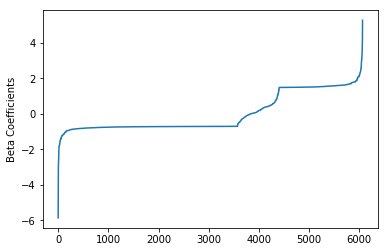

In [101]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()


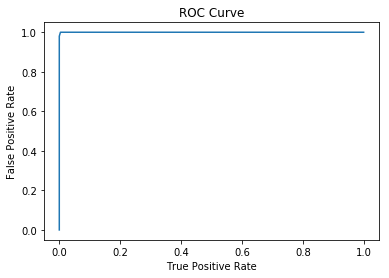

Training set areaUnderROC: 0.9999621212121212


In [102]:
#ROC curve
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [113]:
predictions = lrModel.transform(testsubsetDF)


In [114]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))


IllegalArgumentException: 'Field "label" does not exist.\nAvailable fields: features, int_1, int_2, int_3, int_4, int_5, int_6, int_7, int_8, int_9, int_10, int_11, int_12, int_13, categ_1, categ_2, categ_3, categ_4, categ_5, categ_6, categ_7, categ_8, categ_9, categ_10, categ_11, categ_12, categ_13, categ_14, categ_15, categ_16, categ_17, categ_18, categ_19, categ_20, categ_21, categ_22, categ_23, categ_24, categ_25, categ_26, rawPrediction, probability, prediction'

### Checking stats for columns

In [ ]:
# Let's look at some of the data in histograms
# def plot_hist(hist_list):
#     pd.DataFrame(
#         list(zip(*hist_list)), 
#         columns=['bin', 'frequency']
#     ).set_index(
#         'bin'
#     ).plot(kind='bar');

In [ ]:
# temp_hist = trainDF.select('int_1_log').rdd.flatMap(lambda x: x).histogram(20)


In [ ]:
# plot_hist(temp_hist)


In [ ]:
# tempDF = trainDF.select(["int_1"]).collect()


In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=1)
# fig.set_size_inches(5, 5)
# hist(axes, x=tempDF)

